## Google Drive connection

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1


# TTA tester

In [ ]:
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 43.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import utils
import matplotlib.pyplot as plt
import keras_cv

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tfk = tf.keras
tfkl = tfk.layers

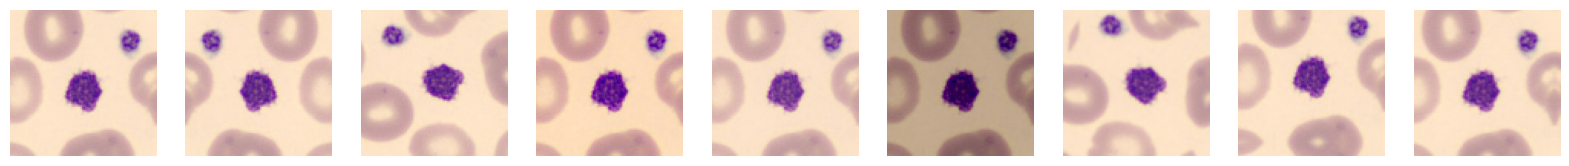

In [ ]:
# Keras layers used as augmentations
rotator = keras_cv.layers.RandomRotation(0.3)
translator_h = keras_cv.layers.RandomTranslation(0.3,0)
translator_w = keras_cv.layers.RandomTranslation(0,0.3)

# Applying TTA augmentations
def _apply_TTA(input):
    aug_input = []
    # Augmenting each image with 8 types of different augmentations
    for elem in input:
        aug_input.append(elem)
        aug_input.append(tf.image.flip_left_right(elem))
        aug_input.append(tf.image.rot90(elem, k=1))
        aug_input.append(tf.image.random_saturation(elem, lower=0.5, upper=1.5))
        aug_input.append(tf.image.random_contrast(elem, lower=0.5, upper=1.5))
        aug_input.append(tf.image.random_brightness(elem, 0.3))
        aug_input.append(rotator(elem))
        aug_input.append(translator_h(elem))
        aug_input.append(translator_w(elem))
    return aug_input

# Loading the dataset
X, y = utils.load_cleaned_dataset()

# Testing on the first sample
samples = np.array([X[0]])
augmented_samples = _apply_TTA(samples)

# Plot the augmentation results
augmented_samples = np.array(augmented_samples)
augmented_samples = augmented_samples.astype(np.uint8)
num_cols = (len(augmented_samples))
fig = plt.figure(figsize=(20, 20))
for i, img in enumerate(augmented_samples):
    x = fig.add_subplot(1, num_cols, i+1)
    x.imshow(img)
    x.axis('off')

In [ ]:
# Loading a specific model saved in our model folder
MODEL = 'efficientnetv2-l_ft_94.42'

In [ ]:
import numpy as np

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

# Model implementation that implements TTA
class Model:
    # Init now includes keras_cv layers
    def __init__(self, augmentation = False):
        self.neural_network = tfk.models.load_model(f'models/{MODEL}.keras')
        self.augmentation = augmentation
        self.rotator = keras_cv.layers.RandomRotation(0.3)
        self.translator_h = keras_cv.layers.RandomTranslation(0.3,0)
        self.translator_w = keras_cv.layers.RandomTranslation(0,0.3)
        self.N_AUG = 9

    # This applies TTA augmentation to a set of images
    def _apply_tta(self,input):
        aug_input = []
        for elem in input:
            aug_input.append(elem)
            aug_input.append(tf.image.flip_left_right(elem))
            aug_input.append(tf.image.rot90(elem, k=1))
            aug_input.append(tf.image.random_saturation(elem, lower=0.5, upper=1.5))
            aug_input.append(tf.image.random_contrast(elem, lower=0.5, upper=1.5))
            aug_input.append(tf.image.random_brightness(elem, 0.3))
            aug_input.append(rotator(elem))
            aug_input.append(translator_h(elem))
            aug_input.append(translator_w(elem))
        return np.array(aug_input)

    # Predict a set of images using a small batch size
    def predict(self, X):
        if self.augmentation:
            X = self._apply_tta(X)
            preds = self.neural_network.predict(X, batch_size=8)

            cluster_size = self.N_AUG
            num_clusters = preds.shape[0] // cluster_size
            reshaped_images = preds.reshape(num_clusters, cluster_size, preds.shape[1])

            mean_pred = np.mean(reshaped_images, axis=1)
            res = np.argmax(mean_pred, axis=-1)
        else:
            preds = self.neural_network.predict(X, batch_size=8)
            res = np.argmax(preds, axis=-1)
        return res

In [ ]:
# Instantiating 2 models, using the same weights and layers, to compare performance
model = Model()
aug_model = Model(augmentation = True)

In [ ]:
# Obtaining the same test dataset that we used during training
X, y = utils.load_cleaned_dataset()
X_train, X_val, X_test, y_train, y_val, y_test = utils.split_dataset(X, y, test_size=0.1, val_size=0.2)

In [ ]:
# Predict classes on the non-TTA model
test_predictions = model.predict(X_test)

150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 178ms/step


In [ ]:
# Predict classes on the TTA model
aug_test_predictions = aug_model.predict(X_test)

1346/1346 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step


In [ ]:
# Compute the differences
accuracy = accuracy_score(y_test, test_predictions)
aug_accuracy = accuracy_score(y_test, aug_test_predictions)
print(f'{round(accuracy,4)} vs {round(aug_accuracy,4)}')

precision = precision_score(y_test, test_predictions, average='weighted')
aug_precision = precision_score(y_test, aug_test_predictions, average='weighted')
print(f'{round(precision,4)} vs {round(aug_precision,4)}')

recall = recall_score(y_test, test_predictions, average='weighted')
aug_recall = recall_score(y_test, aug_test_predictions, average='weighted')
print(f'{round(recall,4)} vs {round(aug_recall,4)}')

f1 = f1_score(y_test, test_predictions, average='weighted')
aug_f1 = f1_score(y_test, aug_test_predictions, average='weighted')
print(f'{round(f1,4)} vs {round(aug_f1,4)}')

0.9841 vs 0.9866
0.9846 vs 0.9869
0.9841 vs 0.9866
0.9842 vs 0.9867


# CodaBench Submitter

This submission didn't work on codabench. It gave us memory problems and we couldn't fix it in any way, not even reducing the prediction batch size nor the number of augmentation to just 2.
For this reason we do not have a performances on codabench with TTA.
We used this to prove that, if TTA is being used properly, it improves prediction accuracy.

In [ ]:
MODEL = 'efficientnetv2-l_ft_94.42'

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
import keras_cv

class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('weights.keras')
        self.rotator = keras_cv.layers.RandomRotation(0.3)
        self.translator_h = keras_cv.layers.RandomTranslation(0.3,0)
        self.translator_w = keras_cv.layers.RandomTranslation(0,0.3)
        self.N_AUG = 8 + 1

    def _apply_tta(self,input):
        aug_input = []
        for elem in input:
            aug_input.append(elem)
            aug_input.append(tf.image.flip_left_right(elem))
            aug_input.append(tf.image.rot90(elem, k=1))
            aug_input.append(tf.image.random_saturation(elem, lower=0.5, upper=1.5))
            aug_input.append(tf.image.random_contrast(elem, lower=0.5, upper=1.5))
            aug_input.append(tf.image.random_brightness(elem, 0.3))
            aug_input.append(self.rotator(elem))
            aug_input.append(self.translator_h(elem))
            aug_input.append(self.translator_w(elem))

        return np.array(aug_input)

    def predict(self, X):
        X = self._apply_tta(X)
        preds = self.neural_network.predict(X, batch_size=8)

        cluster_size = self.N_AUG
        num_clusters = preds.shape[0] // cluster_size
        reshaped_images = preds.reshape(num_clusters, cluster_size, preds.shape[1])

        mean_pred = np.mean(reshaped_images, axis=1)
        res = np.argmax(mean_pred, axis=-1)
        return res

Writing model.py


In [ ]:
from datetime import datetime
from google.colab import files

filename = f'submission_{MODEL}_TTA.zip'

!cp models/{MODEL}.keras weights.keras
!zip {filename} model.py weights.keras
!mv {filename} submissions/

!rm model.py weights.keras

  adding: model.py (deflated 67%)
  adding: weights.keras (deflated 7%)
